In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Supervised Machine Learning - 

After dimensionality reduction, we can now use supervised learning methods to train a classifier and make predictions from new signals. The aim of this notebook is to perform some basic testing to compare the following classifiers with time series data - 

* Logistic Regression
* Support Vector Machines
* Naive Bayes
* Decision Trees
* Random Forest
* K-Nearest Neighbours
* Neural Network
<br>
<br>

After the testing, we select the algorithm with overall best performance and optimize it further. 

__Methodology__ - The data first undergoes PCA transformation to reduce the dimensionality. Then, for each classifier, we perform training with grid search and cross validation to find the optimal choice of parameters. Each classifier is trained with 40-90% of the original data and tested with the remaining dataset. Overfitting is checked by comparing the training scores with cross validation scores.  



In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time, glob, os, math
from matplotlib import cm 
from CommonFunctions import *

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

#Classifiers
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier



import matplotlib as mpl
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)



In [3]:
random_state = 100

In [4]:
os.chdir('/localdata2/bkhamesra3/MachineLearning/GW-MLClassification/Data/')


## Building Data

Collect all waveforms and spin-type. Convert the spin-type category from string to numerical labels. 

In [5]:
#Loading the Dataset

waveform_collection = []
GT_filepaths = sorted(glob.glob("FilteredData/GT*.txt"))
SXS_filepaths = sorted(glob.glob("FilteredData/SXS*.txt"))


for wf_file_gt in GT_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_gt).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_gt, metadata_file)
    waveform_collection.append(wf)
    
for wf_file_sxs in SXS_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_sxs).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_sxs, metadata_file)
    waveform_collection.append(wf)
    


In [6]:
#Concatenate plus and cross polarization
def concat_wf_timedata(wf):
    '''Concatenate the real and imaginary components of waveform in time domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((wf.hp, wf.hx))
    
    return data

def concat_wf_freqdata(wf):
    '''Concatenate the plus and cross polarization components of waveform in frequency domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((np.absolute(wf.hf_plus)[wf.freq>0], np.absolute(wf.hf_cross)[wf.freq>0]))
    
    return data


waveform_collection  = np.asarray(waveform_collection)

waveform_nospin  = []
waveform_alignspin  = []
waveform_precess  = []


for wf in waveform_collection:
    if wf.spin_type=='Precessing':
        waveform_precess.append(wf)
    elif wf.spin_type=='NonSpinning':
        waveform_nospin.append(wf)
    else: 
        waveform_alignspin.append(wf)

        
wf_precess_select50 =  np.random.choice(waveform_precess, size=50, replace=False)

wf_collection_short = np.asarray(waveform_nospin + waveform_alignspin + list(wf_precess_select50))



# waveform_data_ht - each row represents concatenated data corresponding to one waveform in order (t, real, imag)
waveform_data_ht = list(map(concat_wf_timedata, wf_collection_short))
waveform_data_ht = np.matrix(waveform_data_ht)

# waveform_data_hf - each row represents concatenated data corresponding to one waveform in order (f, FT(real), FT(imag))
waveform_data_hf = list(map(concat_wf_freqdata, wf_collection_short))
waveform_data_hf = np.matrix(waveform_data_hf)



# Output
y = [wf.spin_type for wf in wf_collection_short]

# Convert spin labels from string to numbers
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)



In [7]:
#Train a classifier and analyse results

def analyse_classifier(clf, params, data, y, trainingdata_frac, pca_numcomp, rs, verbose=0, show_plot=True, parallelize=False):
    '''Train classifier for given training data size and evaluate the performance. 
    ----------------------------------------------------------------------------------------
    clf - ML classifier (sklearn clf object)
    params (type dict) - dict with parameter name as key and range of parameter values
    to search over (check GridSearch algorithm)
    data (numpy matrix) - input dataset X
    y (numpy array) - output dataset Y
    traindata_frac(float) - numpy array of fraction of training data with each element between 0 to 1
    pca_numcomp(int) - number of PCA components
    rs (int) - random state
    show_plot(boolean) - display plot of performance of classifier
    verbose(int) - print summary of results
    parallelize (boolean) - parallelize grid search 
    '''
    
    clf_cv_score_mean, clf_cv_score_std, clf_train_score_arr, clf_test_score_arr, clf_total_time_arr = \
                                                                            np.zeros((5, len(trainingdata_frac)))
    clf_output = {}
    
    print('-'*100)

    #Run the ML model over training dataset and evluate its performance using cross valiation, testing and time taken
    for i in range(len(trainingdata_frac)):
        
        clf_performance = ml_classifier(clf, params, data, y, trainingdata_frac[i], pca_numcomp, rs, verbose=verbose,parallelize=parallelize)
        clf_cv_score_mean[i]   =  clf_performance.cv_score.mean()
        clf_cv_score_std[i]    =  clf_performance.cv_score.std()
        clf_train_score_arr[i] =  clf_performance.training_score
        clf_test_score_arr[i]  =  clf_performance.testing_score
        clf_total_time_arr[i]  =  clf_performance.total_time
        clf_output[trainingdata_frac[i]] = clf_performance
        if verbose>0: print("Training Fraction = {:0.2g}, Best Model parameters - {}".format(trainingdata_frac[i], clf_performance.best_params))
    
    #Plots the performance of the classifier
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))      
    
    cv_plot = ax1.plot(trainingdata_frac, clf_cv_score_mean, c='C1', label=r'$CV Score $')
    #ax1.plot(trainingdata_frac, clf_cv_score_mean+2*clf_cv_score_std, ls='--', c='C1' )
    #ax1.plot(trainingdata_frac, clf_cv_score_mean-2*clf_cv_score_std, ls='--', c='C1' )
    #ax1.fill_between(trainingdata_frac, clf_cv_score_mean-2*clf_cv_score_std, clf_cv_score_mean, color='C1', alpha=0.3)
    #ax1.fill_between(trainingdata_frac, clf_cv_score_mean+2*clf_cv_score_std, clf_cv_score_mean, color='C1', alpha=0.3)
    ax1.plot(trainingdata_frac, clf_train_score_arr, ls='--', c='C2', label='Training Score')
    ax1.plot(trainingdata_frac, clf_test_score_arr, c='C0', label='Test Score')
     
    ax1.set_xlabel('Training Size')
    ax1.set_ylabel('Scores')
    ax1.legend()
    
    ax2.plot(trainingdata_frac, clf_total_time_arr )
    ax2.set_xlabel('Training Size')
    ax2.set_ylabel('Total Time')
            
    if show_plot:fig.suptitle(clf_performance.name, fontsize=15)
    if show_plot: plt.show()
    plt.close()
    
    return clf_output

## Comparing Classifiers

###  Logistic Regression 

Let's start with a linear model. Logistic Regression method can be used to model the probability distribution for Y given the dataset X. In this model, we estimate the log likelihood of observing Y given X as
<br>
<br>
$$\log (\mathcal{L}(W|Y;X)) = log(\mathcal{P}(Y|X,W)) = \sum log (\mathcal{P}(y_i|x_i, W))$$
<br>
where conditional probability of y is given in terms of sigmoid function as 
$$\mathcal{P}(Y=1|X,W) = \frac{1}{1+e^{-W^TX}}$$
$$\mathcal{P}(Y=0|X,W) = 1-\frac{1}{1+e^{-W^TX}}$$
<br>
To find $W$, one needs to maximize the likelihood estimate, which can be achieved using different solvers. To avoid overfitting and for numerical stability, sklearn adds a regularization term of form $||W||_1$ (L1 Regularization) or $||W^TW||_2$ (L2 regularization) to the cost function, strength of which is controlled by 1/C. Hence, we perform a grid search over these two parameters. The penalty is fixed to 'l2' due to limited support for different solvers. 

__Parameters__ - 
* Fixed - Here, we use 'L2' type regularization term due to limited compatibility of 'L1' with different solvers. Maximum number of iterations are increased from 100 (default) to 1000 for proper convergence. 
* Variable - Regularization strength parameter 'C' is varied over from 0.001-10 and different solvers are tested. 


__Results__ -  

* Training - We see that logistic regression does not work quite efficiently with only 60-80% training scores and  low cross validation scores. Exact scores vary depending on selected data and randomization. 
* Test scores are also extremely low, in some cases lower than CV scores. This is expected since these waves are solutions of II order coupled PDEs and hence Linear classifier should not be expected to work efficiently. 


In [8]:
%%time
clf = LogisticRegression(penalty='l2', max_iter=1000)  
params={'C':10.**np.arange(-3,1,1),'solver':['newton-cg', 'lbfgs','sag', 'saga']}
verbose=1 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.1)

lr = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, parallelize=True, show_plot=False)
print("Parameter analysis completed \n\n")
    
    

----------------------------------------------------------------------------------------------------


/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Fraction = 0.5, Best Model parameters - {'C': 1.0, 'solver': 'saga'}


/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Fraction = 0.6, Best Model parameters - {'C': 0.1, 'solver': 'newton-cg'}
Training Fraction = 0.7, Best Model parameters - {'C': 0.1, 'solver': 'newton-cg'}
Training Fraction = 0.8, Best Model parameters - {'C': 0.01, 'solver': 'newton-cg'}
Parameter analysis completed 


CPU times: user 3.44 s, sys: 662 ms, total: 4.1 s
Wall time: 10.3 s


/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


----------------------------------------------------------------------------------------------------


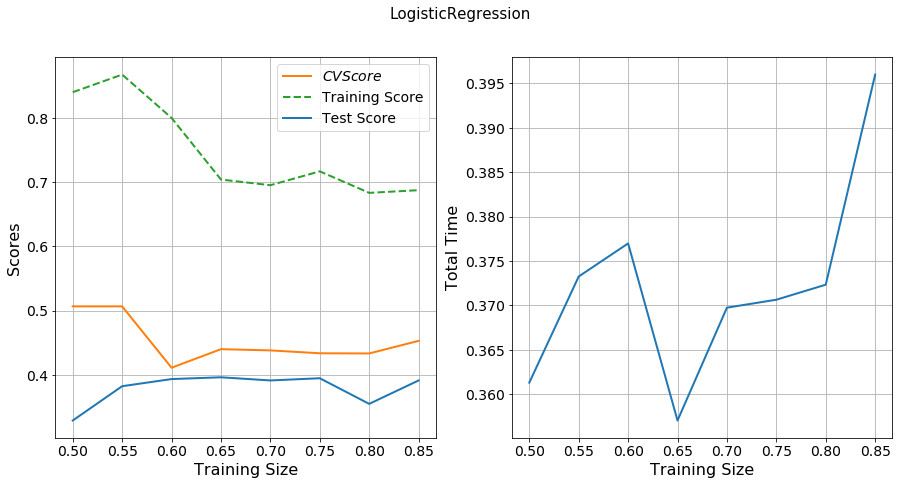

In [9]:
def find_bestparam(param_name):
    '''Finds best parameters for a range of training data'''
    a = np.asarray([lr[key].best_params[param_name] for key in lr.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_C = find_bestparam('C')
best_solver = find_bestparam('solver')

clf = LogisticRegression(penalty='l2', max_iter=1000, C=best_C, solver=best_solver, random_state=random_state)  
params={}
verbose=0

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)
lr_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, parallelize=True, show_plot=True)


### Decision Trees

We now test how the results differ with a non-linear classifier. Decision trees segregate data based on individual features which are selected based on maximum Shanon's entropy or gini index. To avoid overfitting we place the limit of the depth of the tree. Here we perform a grid search over these two parameters.
<br>
<br>
__Parameters__ - 
* Variable - criterion -  max_depth of the tree


__Results__:

* Best Modeling parameters - Lower depth is preferred with smaller training fraction and higher depth trees are preferred for larger training data. 
* Results improve significantly with Decision Trees compared to Logistic Regression. While training scores are extremely high, CV scores lie in range of 60-75%.
* Test scores behavior align well with CV scores attaining accuracies upto 75-80%. 
 

----------------------------------------------------------------------------------------------------
Training Fraction = 0.5, Best Model parameters - {'max_depth': 5}
Training Fraction = 0.55, Best Model parameters - {'max_depth': 5}
Training Fraction = 0.6, Best Model parameters - {'max_depth': 7}
Training Fraction = 0.65, Best Model parameters - {'max_depth': 8}
Training Fraction = 0.7, Best Model parameters - {'max_depth': 8}
Training Fraction = 0.75, Best Model parameters - {'max_depth': 5}
Training Fraction = 0.8, Best Model parameters - {'max_depth': 6}
Training Fraction = 0.85, Best Model parameters - {'max_depth': 9}
Parameter analysis completed 


----------------------------------------------------------------------------------------------------


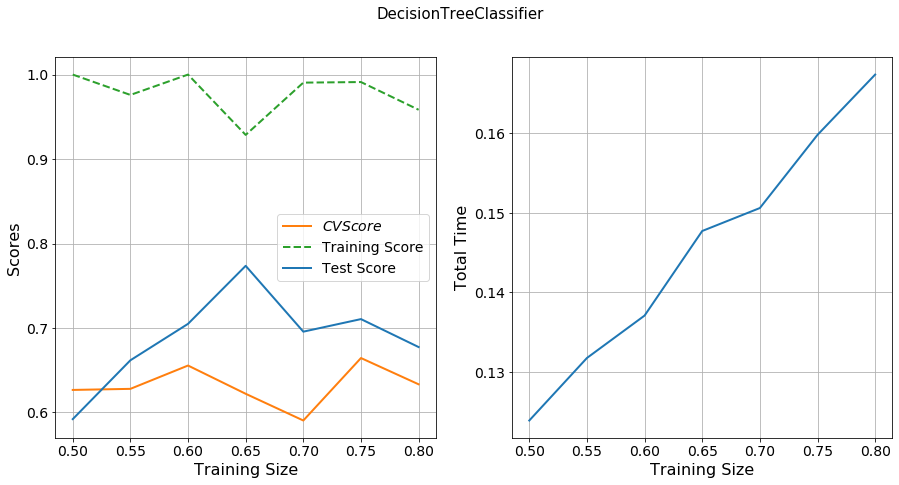

CPU times: user 8.32 s, sys: 3.55 s, total: 11.9 s
Wall time: 3.69 s


In [10]:
%%time

dt = {}
clf = DT(random_state=random_state)
params={'max_depth':[5,6,7,8,9,10]}
verbose=1

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)
pca_comp = 30
dt = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, pca_comp, random_state, verbose=verbose, show_plot=False)
print("Parameter analysis completed \n\n")

verbose=0
clf = DT(criterion='entropy', max_depth=7, random_state=random_state)
n  = np.arange(0.5,0.85,0.05)
params={}

dt_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, pca_comp, random_state, verbose=verbose, show_plot=True)
    

###  Random Forest

Random Forest utilizes bagging technique by training several weak learners on samples of data and then assigns labels based on the average scores of all learners. One of the problems with decision trees include fitting the noise along with the real data which leads to bad testing scores. However, averaging over multiple trees can help reduce the variance of the model thus limiting this problem. Again, as in decision trees, we consider the max_depth of each tree and attribute selection criterion for optimization. We also consider a wide range of learners (n_estimators). 

__Results__ : 
* The results between testing and cross validation scores are  more comparable in this case attaining similar accuracies. 
* The overall performance has also improved with cross validation scores and test scores reaching 80-85%.
* Training multiple decision trees can be expensive which leads to significant increase in the training time. 

In [11]:
%%time
clf = RandomForestClassifier(n_jobs=1, random_state=random_state)
params={'n_estimators':[10,20,30,40],'criterion':['gini', 'entropy'],'max_depth':[7,8,9,10,12]}
verbose=1  

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.1)
rf = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, show_plot=False)

print("Parameter analysis completed \n\n")



----------------------------------------------------------------------------------------------------
Training Fraction = 0.4, Best Model parameters - {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 40}
Training Fraction = 0.5, Best Model parameters - {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 20}
Training Fraction = 0.6, Best Model parameters - {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 40}
Training Fraction = 0.7, Best Model parameters - {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 40}
Training Fraction = 0.8, Best Model parameters - {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 30}
Parameter analysis completed 


CPU times: user 2min 41s, sys: 1.89 s, total: 2min 42s
Wall time: 2min 40s


----------------------------------------------------------------------------------------------------


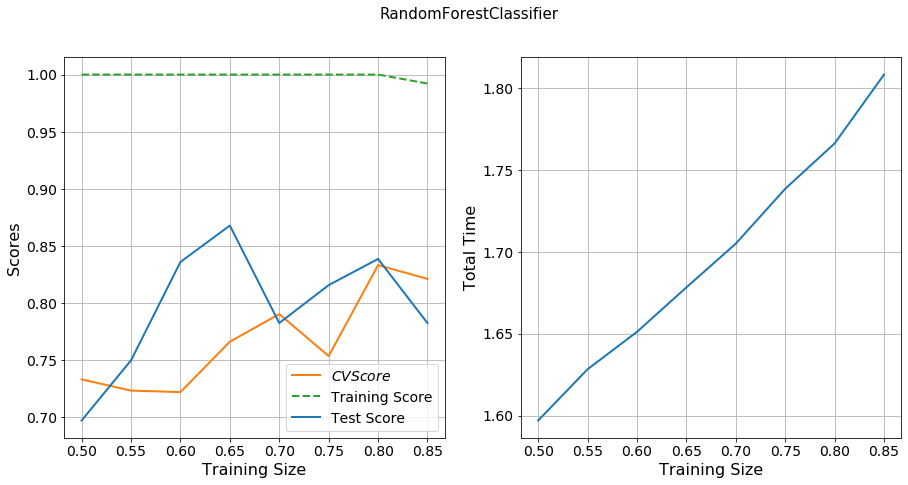

In [12]:
def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_criterion = find_bestparam(rf,'criterion')
best_max_depth = find_bestparam(rf,'max_depth')
best_n_estimator = find_bestparam(rf,'n_estimators')


verbose=0
clf = RandomForestClassifier(n_jobs=1, criterion=best_criterion, n_estimators= best_n_estimator, max_depth=best_max_depth, random_state=random_state)
params={}#'n_estimators':[5,10,20,40],'criterion':['gini', 'entropy'],'max_depth':[6,7,8,9]}
n  = np.arange(0.5,0.9,0.05)
params={}

rf_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, show_plot=True)
    

###  K-Nearest Neighbours (KNN)

KNN utilizes instance based learning approach by choosing K nearest neighbours and predicting the output using majority vote. SKLearn allows two ways to compute the majority weight - first using uniform weights to all the neighbours and second by assigning the weights based on inverse distance metric. To compute the distance, it again uses two different ways - L1 norm and L2 norm. We search over these three parameters to find the best scores. 

__Parameters__ - 
* n_neighbours - Number of nearest neighbours
* Weight - weight for each neighbour's vote
* p - Distance parameter (L1/L2 norm)


__Results__:
* We see that for most training data size, small number of nearest neighbours work well. The weight itself can be uniform or weighted by distance from the original point computed using L1 norm. 
* Training scores are lower than Random Forest or Decision Trees. CV and test scores are comparable reaching the accuracies of 80% or more.
* This method is also extremely fast on par with Decision Trees. 



In [13]:
%%time
clf = KNeighborsClassifier()
params={'n_neighbors':[1,3,5,7,9,15,20],'weights':['uniform', 'distance'], 'p':[1,2]}
        
rf = {}
verbose=1  

#Finding optimal training data size    
n  = np.arange(0.4,0.85,0.05)

knn = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, show_plot=False)

----------------------------------------------------------------------------------------------------
Training Fraction = 0.4, Best Model parameters - {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.45, Best Model parameters - {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.5, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.55, Best Model parameters - {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.6, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.65, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.7, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.75, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.8, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
CPU times: us

----------------------------------------------------------------------------------------------------


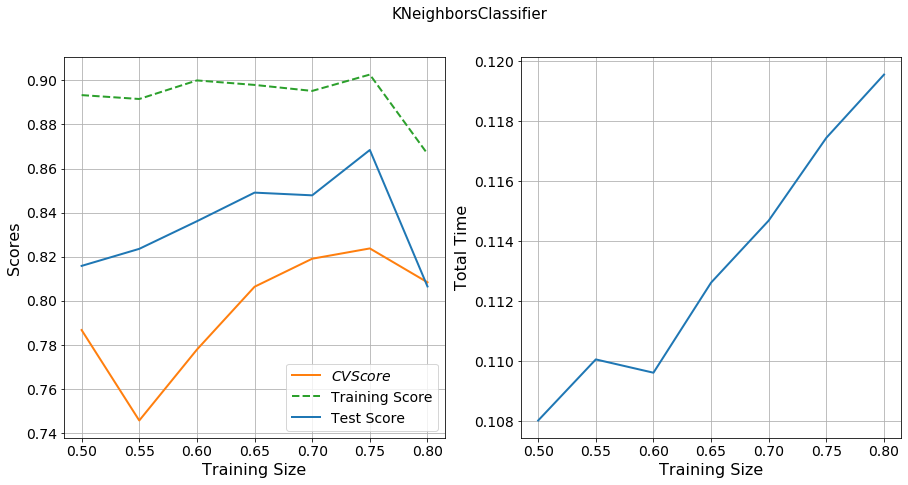

CPU times: user 3.12 s, sys: 1.67 s, total: 4.79 s
Wall time: 1.02 s


In [14]:
%%time

def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_n_neighbors = find_bestparam(knn,'n_neighbors')
best_weight = find_bestparam(knn,'weights')
best_p = find_bestparam(knn,'p')

clf = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weight, p=best_p)
params={}
verbose=0  

#Finding optimal training data size    
n  = np.arange(0.5,0.85,0.05)

knn_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, show_plot=True)

### Classifier : Support Vector Machines (SVM)

 SVM is another linearized method which assumes that the data is linearly separable in some n-dimensional space. The original m-dimensional data is mapped to higher dimensions and the problem essentially reduces to finding the hyperplane which maximizes the margin between the support vectors i.e. the distance of plane from nearest points of each class. Mathematically, if $\mathbf{x}_i \in \mathbb{R}^m$ is the training data and Y is the corresponding set of labels, where each label $y_i \in \{-1,1\}^n$, then SVM assumes that there exists a hyperplane of form $\mathbf{w}^T \phi(\mathbf{x_i}) + b = 0$ which separates the two classes. Here, $\phi(\mathbf(x)):\mathbb{R}^m \to \mathbb{R}^n $ is a mapping function. To find this surface, SVM minimizes
 $$\frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{i} \epsilon_i$$ 
 where the first term is the inverse of the margin length and second term corresponds to penalty associated with misclassified points. Here, C is inverse regularization parameter. This minimization problem is to be solved under the  constraints that $\epsilon_i\geq 0$ and $y_i (\mathbf{w}^T \phi(\mathbf{x}_i + b) \geq 1- \epsilon_i$
 
 __Parameters:__
 SVM is ideally a binary classifier and hence for k multi-class labels, we use 'ovr' approach which construct k classifiers. We vary over the regularization parameter and kernel basis which provides the mapping function to transform data to higher dimensions.
 
 __Results:__
 * Best parameters - Radial Basis kernel function is preferred. Regularization strengths vary ranging from low to high. 
 * Training scores are extremely high, on par with random forest. CV scores are slightly lower than KNN and Random Forest in range of 70-80% but test scores are again higher >80%. Timescales are on par with KNN. .

In [15]:
%%time
clf = SVC(decision_function_shape='ovr', random_state=random_state)  
params=[{'C':10.**np.arange(0,2,0.4),'kernel':['poly', 'rbf', 'sigmoid']}]
rf = {}
verbose=1

#Finding optimal training data size    
n  = np.arange(0.4,0.85,0.05)
svm = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, parallelize=True, show_plot=False)


----------------------------------------------------------------------------------------------------
Training Fraction = 0.4, Best Model parameters - {'C': 6.309573444801933, 'kernel': 'rbf'}
Training Fraction = 0.45, Best Model parameters - {'C': 6.309573444801933, 'kernel': 'rbf'}
Training Fraction = 0.5, Best Model parameters - {'C': 15.848931924611142, 'kernel': 'rbf'}
Training Fraction = 0.55, Best Model parameters - {'C': 39.810717055349734, 'kernel': 'rbf'}
Training Fraction = 0.6, Best Model parameters - {'C': 39.810717055349734, 'kernel': 'rbf'}
Training Fraction = 0.65, Best Model parameters - {'C': 39.810717055349734, 'kernel': 'rbf'}
Training Fraction = 0.7, Best Model parameters - {'C': 2.51188643150958, 'kernel': 'rbf'}
Training Fraction = 0.75, Best Model parameters - {'C': 6.309573444801933, 'kernel': 'rbf'}
Training Fraction = 0.8, Best Model parameters - {'C': 2.51188643150958, 'kernel': 'rbf'}
CPU times: user 6.76 s, sys: 2 s, total: 8.76 s
Wall time: 4.57 s


----------------------------------------------------------------------------------------------------


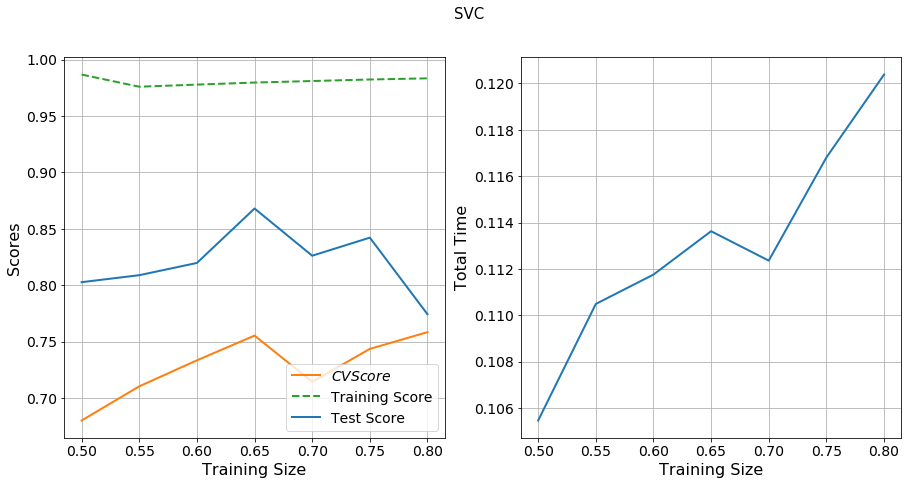

In [16]:
def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_C = find_bestparam(svm,'C')
best_kernel = find_bestparam(svm,'kernel')


clf = SVC(decision_function_shape='ovr', kernel=best_kernel, C=best_C, random_state=random_state)  
params={}

verbose=0

#Finding optimal training data size    
n  = np.arange(0.5,0.85,0.05)
svm_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, parallelize=True, show_plot=True)


### Classifier : Gaussian Naive Bayes

Naive Bayes applies Bayesian statistical model with assumption of conditional independence. Given a set of features $x_1...x_n$, from Bayes theorem, the posterior probability is given as
$$ P(y|x_1...x_n) = \frac{P(y) P(x_1...x_n|y)}{P(x_1...x_n)}$$

Under conditional independence, we assume that $P(x_1|x_2...x_n, y) = P(x_1|y)$ and hence, 

$$ P(y|x_1...x_n) \propto P(y) \prod_{i=1}^n P(x_i|y)$$

Then, the correct classifier label corresponds to maximizing posterior probability or MAP estimation which can be computed in terms of prior and likelihood using the above assumption. Gaussian Naive Bayes makes following assumption on the likelihood estimation -  

$$ P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right) $$

__Results__ - 
* Naive Bayes performs really well. The training, CV and test scores are all aligned in the range of 75-85%. 
* One of the reasons this works in due to application of PCA  which results in mutually independent components with 0 covariance. 

----------------------------------------------------------------------------------------------------


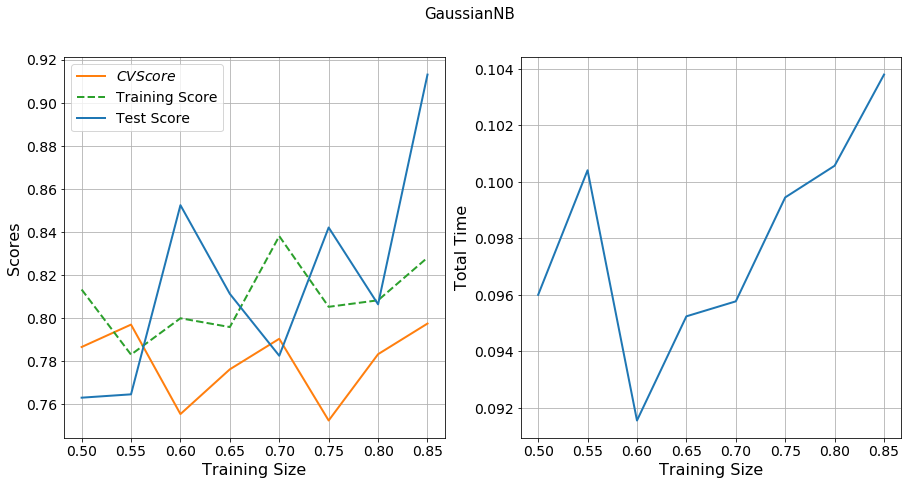

CPU times: user 3.07 s, sys: 1.86 s, total: 4.93 s
Wall time: 1.02 s


In [17]:
%%time
clf = GaussianNB()  
params={} 
        
rf = {}
verbose=0 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)

gnb = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, parallelize=True, show_plot=True)


### Classifier : Neural Network





In [22]:
%%time
clf = MLPClassifier(alpha=0.1, solver='adam', max_iter=1000, random_state=random_state)  
params={ 'hidden_layer_sizes':[(10,10,10),(50,50,50),(100,100,100)], 'activation':['identity', 'logistic', 'tanh', 'relu']} 

verbose=1 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.1)
ann = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, parallelize=True, show_plot=False)


----------------------------------------------------------------------------------------------------
Training Fraction = 0.5, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50)}
Training Fraction = 0.6, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100)}
Training Fraction = 0.7, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100)}
Training Fraction = 0.8, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100)}
CPU times: user 51.9 s, sys: 25.7 s, total: 1min 17s
Wall time: 2min 53s


----------------------------------------------------------------------------------------------------


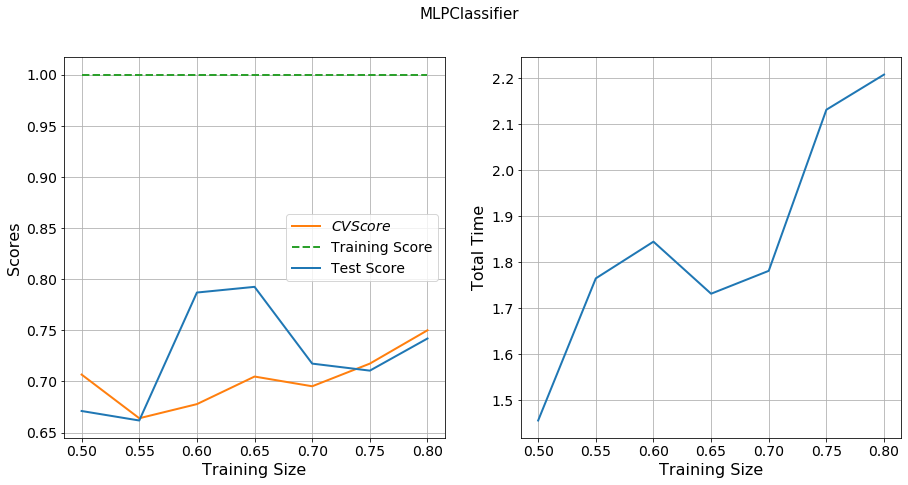

CPU times: user 12.8 s, sys: 6.09 s, total: 18.9 s
Wall time: 13.1 s


In [19]:
%%time

def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]  
    
best_hlayer_size = find_bestparam(ann,'hidden_layer_sizes')
best_activation = find_bestparam(ann,'activation')


clf = MLPClassifier(alpha=0.1, solver='adam', hidden_layer_sizes=best_hlayer_size, activation=best_activation, max_iter=1000, random_state=random_state)  
params={ }#'hidden_layer_sizes':[10,50,100,200], 'activation':['identity', 'logistic', 'tanh', 'relu']} 

verbose=0 

#Finding optimal training data size    
n  = np.arange(0.5,0.85,0.05)
ann_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 30, random_state, verbose=verbose, parallelize=True, show_plot=True)


/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


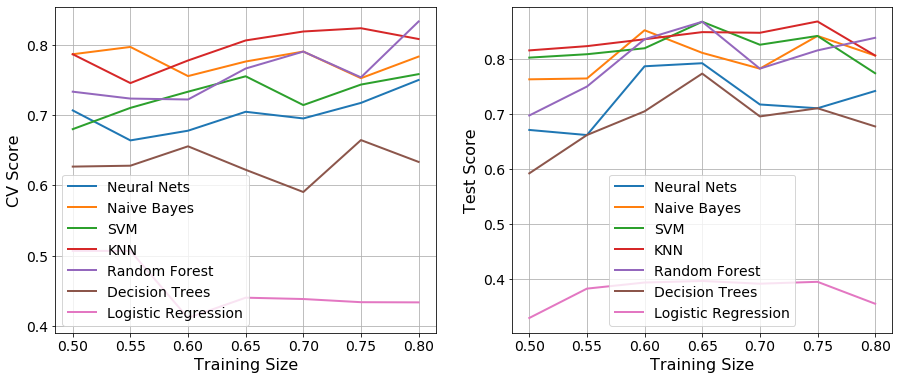

In [21]:
#Model Comparisons

plt.figure(figsize=(15,6))
clf = {'Neural Nets':ann_final, 'Naive Bayes': gnb, 'SVM':svm_final,\
       'KNN':knn_final,'Random Forest':rf_final, 'Decision Trees':dt_final,'Logistic Regression':lr_final }

clf_crossval_score = lambda train_size: clf_new[train_size].cv_score.mean()
clf_test_score = lambda train_size: clf_new[train_size].testing_score

for key in clf.keys():
    clf_new = clf[key]
    
    plt.subplot(121)
    
    #plt.plot(train_size,classifier[train_size].cv_score.mean())
    plt.plot(n, list(map(clf_crossval_score, n)), label=key)
    plt.xlabel('Training Size')
    plt.ylabel('CV Score')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(n, list(map(clf_test_score, n)), label=key)
    plt.xlabel('Training Size')
    plt.ylabel('Test Score')
    #plt.ylim(0.65,0.87)
    plt.legend()

    
plt.show()

       